In [256]:
%cd ..

/home


In [257]:
import pandas as pd

In [294]:
from util.sql_switch import get_query_native

authors_tweets = get_query_native(
    "SELECT ta.id as author_id, conversation_id, screen_name , is_climate_author, climate_author_type FROM delab_tweet t, delab_tweetauthor ta WHERE t.author_id=ta.twitter_id")
#tweet_count = authors_tweets.reset_index()
#tweet_count = tweet_count['conversation_id'].value_counts()
#tweet_count = tweet_count.to_frame()
#print(tweet_count)
#tweet_count_test= tweet_count[tweet_count["conversation_id"] == 1595778267218419712]
#print(tweet_count_test)
clauthors_tweets = authors_tweets.loc[authors_tweets['is_climate_author']== True]
#clauthors_tweets = tweet_count.join(clauthors_tweets)

clauthors_tweets = clauthors_tweets.replace(['non-governmental organisation'], 'NGO')
clauthors_tweets = clauthors_tweets.groupby(["author_id", "screen_name", "climate_author_type","conversation_id"]).mean()

c_cam = get_query_native(
    "SELECT author_id, is_root_author, c.conversation_id, depth, branching_factor, centrality, baseline_vision, n_posts FROM delab_conversation c, delab_conversationauthormetrics cam WHERE c.conversation_id=cam.conversation_id")
c_cam = c_cam.groupby(["author_id", "conversation_id"]).mean()

analysis = clauthors_tweets.join(c_cam)
analysis_flattend = analysis.reset_index()
analysis_flattend
#analysis.head()

using postgres
using postgres


/home/pauline/Dokumente/Delab_Projekt/delab/venv/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/home/pauline/Dokumente/Delab_Projekt/delab/venv/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,author_id,conversation_id,screen_name,climate_author_type,is_climate_author,is_root_author,depth,branching_factor,centrality,baseline_vision,n_posts
0,1,1575916410295009308,mnyomb1,activist,1.0,1.0,3.0,5.0,3.500000,0.500000,1.0
1,1,1578084206940487680,mnyomb1,activist,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1582639690309828609,mnyomb1,activist,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,1,1585616351493820416,mnyomb1,activist,1.0,1.0,3.0,21.0,1.444444,0.118056,9.0
4,1,1597566310191624196,mnyomb1,activist,1.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
133,438,1603018871878799360,EUClimateAction,organisation,1.0,1.0,3.0,22.0,20.500000,0.500000,1.0
134,447,1603071731412996097,CANIntl,NGO,1.0,NaN,NaN,NaN,NaN,NaN,NaN
135,450,1597385204204965889,ExtinctionR,NGO,1.0,1.0,4.0,39.0,5.055556,0.141927,6.0
136,450,1610517363216244737,ExtinctionR,NGO,1.0,1.0,5.0,18.0,8.333333,0.500000,1.0


In [296]:
tweet_ids = get_query_native(
                "SELECT conversation_id FROM delab_tweet")
tweet_ids
#tweet_count = tweet_ids.reset_index
tweet_count = tweet_ids['conversation_id'].value_counts()
tweet_count = tweet_count.to_frame()
#tweet_count
tweet_count = tweet_count.rename(columns={"conversation_id":"n_posts"})
tweet_count['conversation_id'] = tweet_count.index
tweet_count

using postgres


/home/pauline/Dokumente/Delab_Projekt/delab/venv/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,n_posts,conversation_id
1595778267218419712,99,1595778267218419712
1601394116184924160,92,1601394116184924160
1611573350471716864,91,1611573350471716864
1598282856425570307,80,1598282856425570307
1610527805925736448,78,1610527805925736448
...,...,...
1599074829222969344,6,1599074829222969344
1582567215643041793,6,1582567215643041793
1599689800612659201,6,1599689800612659201
1612348494936776704,6,1612348494936776704


In [297]:
mapped_columns = dict(zip(tweet_count.conversation_id, tweet_count.n_posts))
analysis_flattend["total_counts"] = analysis_flattend["conversation_id"].map(mapped_columns)
analysis_flattend

,author_id,conversation_id,screen_name,climate_author_type,is_climate_author,is_root_author,depth,branching_factor,centrality,baseline_vision,n_posts,total_counts
0,1,1575916410295009308,mnyomb1,activist,1.0,1.0,3.0,5.0,3.500000,0.500000,1.0,6
1,1,1578084206940487680,mnyomb1,activist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,6
2,1,1582639690309828609,mnyomb1,activist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,60
3,1,1585616351493820416,mnyomb1,activist,1.0,1.0,3.0,21.0,1.444444,0.118056,9.0,22
4,1,1597566310191624196,mnyomb1,activist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,21
...,...,...,...,...,...,...,...,...,...,...,...,...
133,438,1603018871878799360,EUClimateAction,organisation,1.0,1.0,3.0,22.0,20.500000,0.500000,1.0,23
134,447,1603071731412996097,CANIntl,NGO,1.0,NaN,NaN,NaN,NaN,NaN,NaN,38
135,450,1597385204204965889,ExtinctionR,NGO,1.0,1.0,4.0,39.0,5.055556,0.141927,6.0,40
136,450,1610517363216244737,ExtinctionR,NGO,1.0,1.0,5.0,18.0,8.333333,0.500000,1.0,19


## Analyse
- Nach climate_author_type analysieren
- Fragen:
    - in wievielen Konversationen sind die Autoren durchschnittlich vertreten?
    - welche Zentralität haben die AUtoren durchschnittlich?
    - welche root dominance haben die Autoren durchschnittlich?
    - welchen branching_factor und welche depth haben die Konversationen, in denen die Autoren root auhtor sind duchschnittlich?
    

In [298]:
climate_analysis = analysis_flattend.groupby(['climate_author_type']).mean()
climate_analysis = climate_analysis.drop(columns=['author_id', 'conversation_id', 'is_climate_author', 'is_root_author' ])
climate_analysis = climate_analysis.drop('journalist') #bisher sind alle ergebnisse für journalists NaN, deswegen werden wir sie nicht betrachten
climate_analysis

,depth,branching_factor,centrality,baseline_vision,n_posts,total_counts
climate_author_type,,,,,,
NGO,3.967742,19.838710,13.095786,0.448379,1.225806,22.945946
activist,4.058824,13.117647,5.587815,0.372116,2.411765,17.136364
organisation,2.551724,16.551724,14.545977,0.469828,1.172414,17.677419
politician,5.000000,27.600000,14.430952,0.348462,2.000000,24.125000
scientist,4.588235,25.000000,11.746755,0.369993,1.882353,30.090909


In [299]:
import matplotlib.pyplot as plt
import numpy as np

Text(0, 0.5, 'depth')

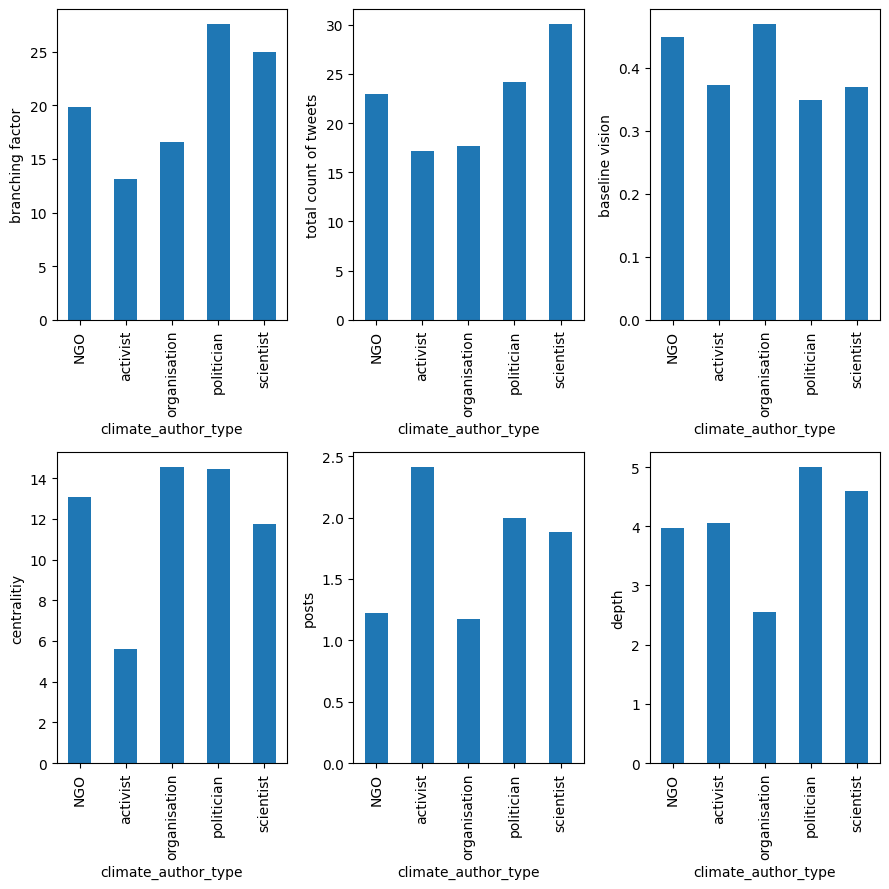

In [327]:
fig, axes = plt.subplots(nrows=2, ncols=3, tight_layout=True, figsize=(9,9))

ax1 = climate_analysis['branching_factor'].plot.bar(ax=axes[0,0])
ax1.set_ylabel("branching factor")

ax2 = climate_analysis['total_counts'].plot.bar(ax=axes[0,1])
ax2.set_ylabel("total count of tweets")

ax3 = climate_analysis['centrality'].plot.bar(ax=axes[1,0])
ax3.set_ylabel("centralitiy")

ax4 = climate_analysis['n_posts'].plot.bar(ax=axes[1,1])
ax4.set_ylabel("posts");

ax5 = climate_analysis['baseline_vision'].plot.bar(ax=axes[0,2])
ax5.set_ylabel("baseline vision")

ax6 = climate_analysis['depth'].plot.bar(ax=axes[1,2])
ax6.set_ylabel("depth")

In [305]:
analysis_flattend.describe()

,author_id,conversation_id,is_climate_author,is_root_author,depth,branching_factor,centrality,baseline_vision,n_posts,total_counts
count,138.000000,1.380000e+02,138.0,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,138.000000
mean,264.297101,1.598786e+18,1.0,0.969697,3.727273,19.000000,12.067123,0.423060,1.565657,23.376812
std,162.925329,1.013300e+16,0.0,0.172292,2.542770,20.109395,13.642386,0.135355,1.415379,20.968939
min,1.000000,1.575844e+18,1.0,0.000000,2.000000,5.000000,1.000000,0.093750,1.000000,6.000000
25%,95.000000,1.596182e+18,1.0,1.000000,2.000000,7.000000,4.777778,0.285156,1.000000,9.000000
50%,358.500000,1.600186e+18,1.0,1.000000,3.000000,11.000000,7.000000,0.500000,1.000000,15.000000
75%,407.000000,1.604407e+18,1.0,1.000000,4.000000,21.000000,13.166667,0.500000,1.000000,28.250000
max,450.000000,1.612348e+18,1.0,1.000000,18.000000,98.000000,74.166667,0.500000,9.000000,99.000000


<AxesSubplot:xlabel='x1', ylabel='total_counts'>

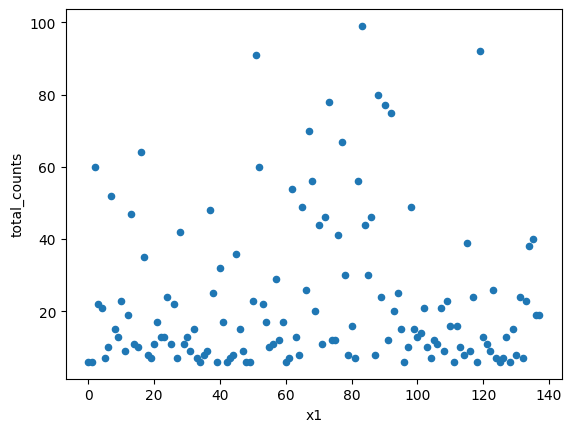

In [302]:
scatter_analysis = analysis_flattend.reset_index()
scatter_analysis = scatter_analysis[scatter_analysis.total_counts > 1]
scatter_analysis['x1'] = scatter_analysis.index
scatter_analysis
scatter_analysis.plot.scatter(x='x1', y="total_counts")

<AxesSubplot:xlabel='x1', ylabel='branching_factor'>

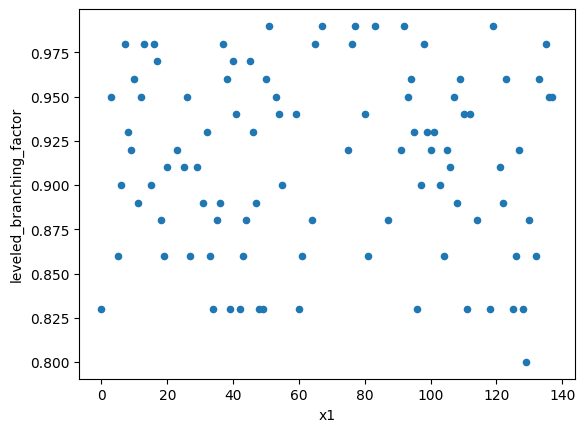

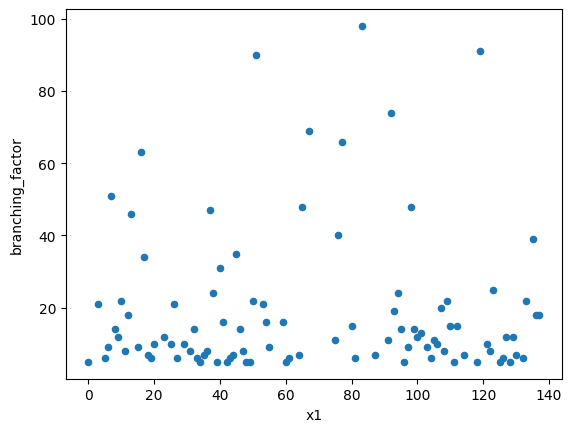

In [320]:
scatter_analysis['leveled_branching_factor']= (scatter_analysis["branching_factor"]/scatter_analysis["total_counts"]).round(2)
scatter_analysis.plot.scatter(x='x1', y="leveled_branching_factor")
scatter_analysis.plot.scatter(x='x1', y="branching_factor")
#Teilen durch total_counts hilft gegen ausreißer

In [317]:
scatter_analysis_case_study = scatter_analysis[scatter_analysis["leveled_branching_factor"] < 0.75]
scatter_analysis_case_study
print(scatter_analysis["leveled_branching_factor"].mean())


0.91319587628866


<AxesSubplot:xlabel='x1', ylabel='leveled_depth'>

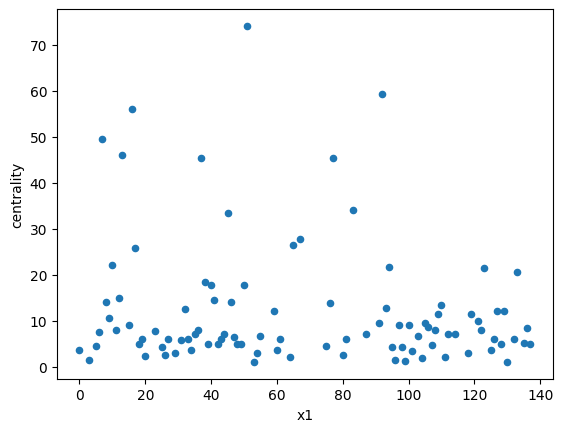

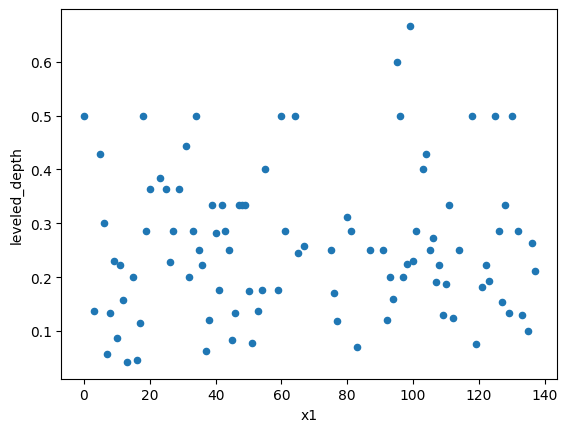

In [337]:
scatter_analysis.plot.scatter(x='x1', y="centrality")
scatter_analysis['leveled_depth']= (scatter_analysis["depth"]/scatter_analysis["total_counts"])
scatter_analysis.plot.scatter(x='x1', y="leveled_depth")

<AxesSubplot:xlabel='x1', ylabel='leveled_centrality'>

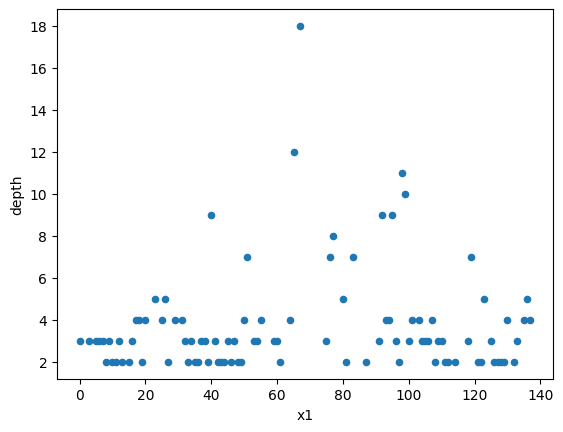

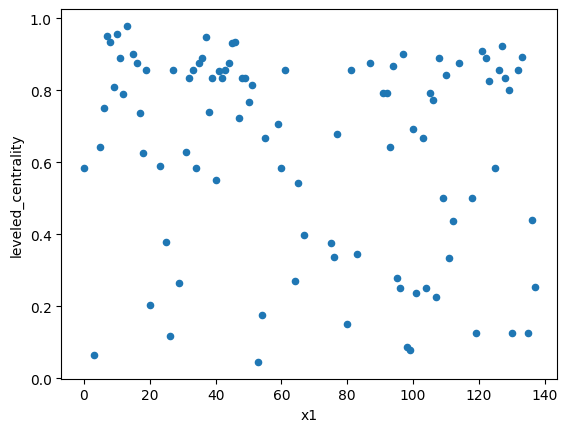

In [322]:
scatter_analysis.plot.scatter(x='x1', y="depth")
scatter_analysis['leveled_depth']= (scatter_analysis["depth"]/scatter_analysis["total_counts"])
scatter_analysis.plot.scatter(x='x1', y="leveled_centrality")

<AxesSubplot:xlabel='x1', ylabel='leveled_baseline_vision'>

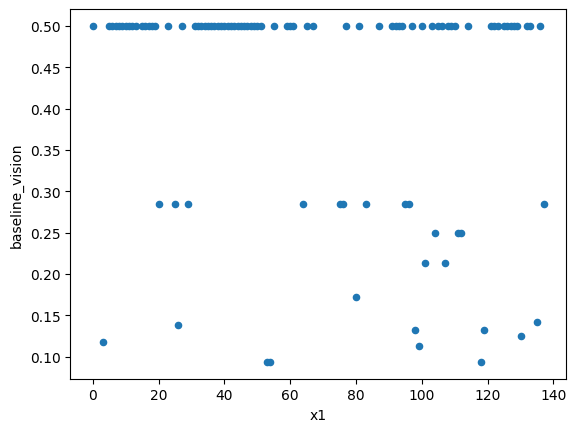

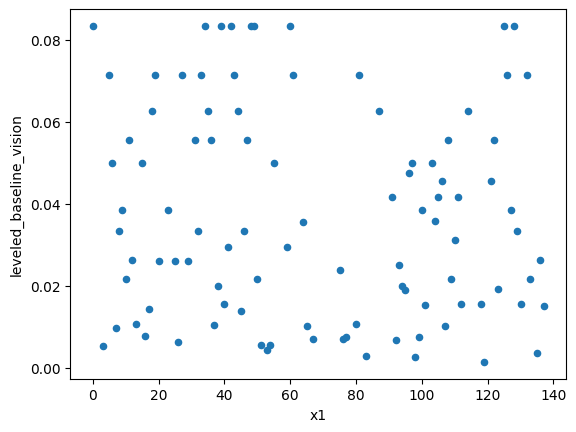

In [323]:
scatter_analysis.plot.scatter(x='x1', y="baseline_vision")
scatter_analysis['leveled_baseline_vision']= (scatter_analysis["baseline_vision"]/scatter_analysis["total_counts"])
scatter_analysis.plot.scatter(x='x1', y="leveled_baseline_vision")
#Macht es hier Sinn durch die Anzahl der Tweets in der Konversation zu teilen?

In [273]:
scatter_analysis_baseline = scatter_analysis[scatter_analysis["baseline_vision"] < 0.15]
scatter_analysis_baseline

,index,author_id,conversation_id,screen_name,climate_author_type,is_climate_author,is_root_author,depth,branching_factor,centrality,baseline_vision,n_posts,total_counts,x1,leveled_branching_factor
3,3,1,1585616351493820416,mnyomb1,activist,1.0,1.0,3.0,21.0,1.444444,0.118056,9.0,22,3,0.95
26,26,93,1602049608787582976,MichaelEMann,scientist,1.0,1.0,5.0,21.0,2.611111,0.138102,6.0,6,26,3.50
53,53,103,1585616351493820416,parents4future,NGO,1.0,0.0,3.0,21.0,1.000000,0.093750,1.0,22,53,0.95
54,54,103,1612073522687270914,parents4future,NGO,1.0,0.0,3.0,16.0,3.000000,0.093750,1.0,2,54,8.00
98,98,407,1599463631132844034,MrMatthewTodd,activist,1.0,1.0,11.0,48.0,4.242857,0.132248,6.0,8,98,6.00
99,99,407,1600617758022307840,MrMatthewTodd,activist,1.0,1.0,10.0,14.0,1.166667,0.113422,6.0,6,99,2.33
119,119,425,1601394116184924160,KHayhoe,scientist,1.0,1.0,7.0,91.0,11.527778,0.132248,6.0,6,119,15.17
130,130,438,1598648601927876610,EUClimateAction,organisation,1.0,1.0,4.0,7.0,1.000000,0.125000,4.0,4,130,1.75
135,135,450,1597385204204965889,ExtinctionR,NGO,1.0,1.0,4.0,39.0,5.055556,0.141927,6.0,6,135,6.50


<AxesSubplot:xlabel='x1', ylabel='leveled_posts'>

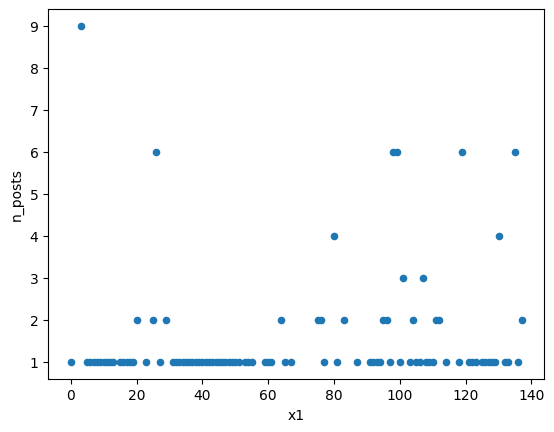

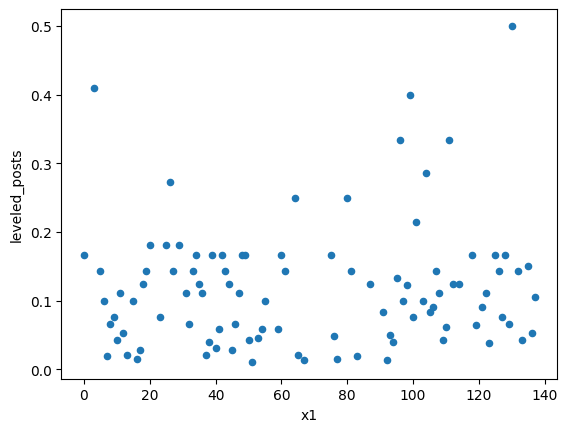

In [324]:
scatter_analysis.plot.scatter(x='x1', y="n_posts")
scatter_analysis['leveled_posts']= (scatter_analysis["n_posts"]/scatter_analysis["total_counts"])
scatter_analysis.plot.scatter(x='x1', y="leveled_posts")

In [325]:
scatter_analysis_posts = scatter_analysis[scatter_analysis["leveled_posts"] > 0.4]
scatter_analysis_posts

,index,author_id,conversation_id,screen_name,climate_author_type,is_climate_author,is_root_author,depth,branching_factor,centrality,baseline_vision,n_posts,total_counts,x1,leveled_branching_factor,leveled_centrality,leveled_depth,leveled_baseline_vision,leveled_posts
3,3,1,1585616351493820416,mnyomb1,activist,1.0,1.0,3.0,21.0,1.444444,0.118056,9.0,22,3,0.95,0.065657,0.136364,0.005366,0.409091
130,130,438,1598648601927876610,EUClimateAction,organisation,1.0,1.0,4.0,7.0,1.000000,0.125000,4.0,8,130,0.88,0.125000,0.500000,0.015625,0.500000


Konversation 3 viele Posts vom Root author aber baseline vision vom root author besonders niedrig

In [335]:
scatter_analysis
leveled_analysis = scatter_analysis.groupby(["climate_author_type"]).mean()
leveled_analysis = leveled_analysis.drop('journalist')

Text(0, 0.5, 'depth')

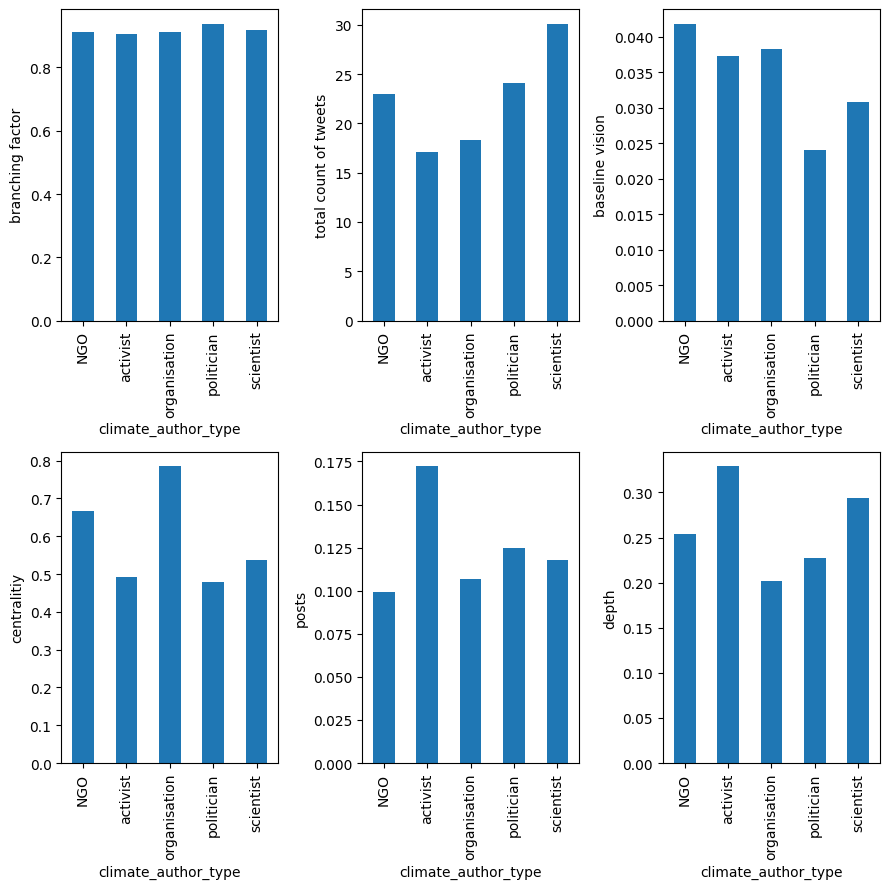

In [336]:
fig, axes = plt.subplots(nrows=2, ncols=3, tight_layout=True, figsize=(9,9))

ax1 = leveled_analysis['leveled_branching_factor'].plot.bar(ax=axes[0,0])
ax1.set_ylabel("branching factor")

ax2 = leveled_analysis['total_counts'].plot.bar(ax=axes[0,1])
ax2.set_ylabel("total count of tweets")

ax3 = leveled_analysis['leveled_centrality'].plot.bar(ax=axes[1,0])
ax3.set_ylabel("centralitiy")

ax4 = leveled_analysis['leveled_posts'].plot.bar(ax=axes[1,1])
ax4.set_ylabel("posts");

ax5 = leveled_analysis['leveled_baseline_vision'].plot.bar(ax=axes[0,2])
ax5.set_ylabel("baseline vision")

ax6 = leveled_analysis['leveled_depth'].plot.bar(ax=axes[1,2])
ax6.set_ylabel("depth")